# STM Transit Delay Data Preparation

## Overview

This notebook cleans and merges data collected from [STM](https://www.stm.info/en/about/developers) and [Open-Meteo](https://open-meteo.com/en/docs) and prepares it for data analysis and/or preprocessing.

## Data Description

### STM Schedule

`trip_id`: Unique identifier for the transit trip.<br>
`arrival_time`, `departure_time`: Scheduled arrival and departure time.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_sequence`: Sequence of a stop, for ordering.

### STM Stops

`stop_id`: Unique identifier of a stop.<br>
`stop_code`: Bus stop or metro station number.<br>
`stop_name`: Bus stop or metro station name<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_url`: Stop web page.<br>
`location_type`: Stop type.<br>
`parent_station`: Parent station (metro station with multiple exits).<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair, 0 meaning "no information", 1 being "accessible" and 2 being "not accessible".

### STM Trips

`route_id`:  Unique identifier for the bus or metro line.<br>
`service_id`: Identifies a set of dates when service is available for one or more routes.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`trip_headsign`: Direction of the trip (Nord, South, West, East).<br>
`direction_id`: Boolean value for the direction.<br>
`shape_id`: Identifies a geospatial shape describing the vehicle travel path for a trip.<br>
`wheelchair_accessible`: Indicates wheelchair accessibility, 0 meaning "no information", 1 being "accessible" and 2 being "not accessible".<br>
`note_fr`, `note_en`: Additionnal comment in French and English.

### STM Real-Time Trip Updates

`current_time`: Timestamp when the data was fetched from the GTFS, in milliseconds.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of the transit trip.<br>
`stop_id`: Unique identifier of a stop.<br>
`arrival_time`, `departure_time`: Realtime arrival and departure time, in seconds<br>
`schedule_relationship`: State of the trip, 0 meaning "scheduled", 1 meaning "skipped" and 2 meaning "no data".

### STM Route Types

`route_id`: Unique identifier for a bus or metro line.<br>
`route_type`: Type of bus line (e.g. Night)<br>

### Open-Meteo Weather API

`time`: Date and hour or the weather.<br>
`temperature_2m`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity_2m`: Relative humidity at 2 meters above ground, in percentage.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure_msl`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`wind_speed_10m`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction_10m`: Wind direction at 10 meters above ground.<br>

## Imports

In [1]:
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from src.constants import LOCAL_TIMEZONE, SCHEDULE_RELATIONSHIP
from src.helper_functions import parse_gtfs_time

In [3]:
# Import data
schedules_df = pd.read_csv('../data/download/stop_times.txt')
stops_df = pd.read_csv('../data/stops_cleaned.csv')
trips_df = pd.read_csv('../data/download/trips.txt')
trip_updates_df = pd.read_csv('../data/api/fetched_stm_trip_updates.csv', low_memory=False)
routes_df = pd.read_csv('../data/route_types.csv')
weather_df = pd.read_csv('../data/api/fetched_historical_weather.csv')

## Merge Data

### Schedules and stops

In [4]:
stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8994 entries, 0 to 8993
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              8994 non-null   int64  
 1   stop_name            8994 non-null   object 
 2   neighbourhood        3434 non-null   object 
 3   stop_lat             8994 non-null   float64
 4   stop_lon             8994 non-null   float64
 5   location_type        8994 non-null   int64  
 6   wheelchair_boarding  8994 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 492.0+ KB


In [5]:
# Sort values by stop sequence
schedules_df = schedules_df.sort_values(by=['trip_id', 'stop_sequence'])

In [6]:
# Add trip progress (vehicles further along the trip are more likely to be delayed)
total_stops = schedules_df.groupby('trip_id')['stop_id'].transform('count')
schedules_df['trip_progress'] = schedules_df['stop_sequence'] / total_stops

In [7]:
# Get distribution of trip progress
schedules_df['trip_progress'].describe()

count    6.629625e+06
mean     5.139220e-01
std      2.887289e-01
min      8.547009e-03
25%      2.631579e-01
50%      5.142857e-01
75%      7.647059e-01
max      1.000000e+00
Name: trip_progress, dtype: float64

In [8]:
# Merge schedules and stops
schedules_stops_df = pd.merge(left=schedules_df, right=stops_df, how='inner', on='stop_id') 

In [9]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'neighbourhood', 'stop_lat', 'stop_lon',
       'location_type', 'wheelchair_boarding'],
      dtype='object')

In [10]:
# Get coordinates of previous stop
schedules_stops_df = schedules_stops_df.sort_values(by=['trip_id', 'stop_sequence'])
schedules_stops_df['prev_lat'] = schedules_stops_df.groupby('trip_id')['stop_lat'].shift(1)
schedules_stops_df['prev_lon'] = schedules_stops_df.groupby('trip_id')['stop_lon'].shift(1)

In [11]:
# Make sure scheduled arrival time has no null values
assert schedules_stops_df['arrival_time'].isna().sum() == 0

In [12]:
# Make sure the null coordinates are from first stops
prev_null_mask = (schedules_stops_df['prev_lat'].isna()) | (schedules_stops_df['prev_lon'].isna())
first_stop_mask = schedules_stops_df['stop_sequence'] == 1
assert prev_null_mask.sum() == first_stop_mask.sum()

In [13]:
# Add column with current date
schedules_stops_df['today'] = pd.Timestamp.now().normalize()
schedules_stops_df['today']

0         2025-05-15
1         2025-05-15
2         2025-05-15
3         2025-05-15
4         2025-05-15
             ...    
6388736   2025-05-15
6388737   2025-05-15
6388738   2025-05-15
6388739   2025-05-15
6388740   2025-05-15
Name: today, Length: 6388741, dtype: datetime64[us]

In [14]:
# Parse arrival time
schedules_stops_df['parsed_time'] = parse_gtfs_time(schedules_stops_df, 'today', 'arrival_time', unit='us')
schedules_stops_df['parsed_time'] 

0         2025-05-15 04:55:00-04:00
1         2025-05-15 04:55:31-04:00
2         2025-05-15 04:56:04-04:00
3         2025-05-15 04:56:31-04:00
4         2025-05-15 04:56:51-04:00
                     ...           
6388736   2025-05-16 01:35:00-04:00
6388737   2025-05-16 01:40:00-04:00
6388738   2025-05-16 01:55:00-04:00
6388739   2025-05-16 01:40:00-04:00
6388740   2025-05-16 01:55:00-04:00
Name: parsed_time, Length: 6388741, dtype: datetime64[ns, Canada/Eastern]

In [15]:
schedules_stops_df.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,trip_progress,stop_name,neighbourhood,stop_lat,stop_lon,location_type,wheelchair_boarding,prev_lat,prev_lon,today,parsed_time
0,280882183,04:55:00,04:55:00,56338,1,0.022222,Kildare / Westminster,NaN,45.462603,-73.671081,0,1,NaN,NaN,2025-05-15,2025-05-15 04:55:00-04:00
1,280882183,04:55:31,04:55:31,56345,2,0.044444,Kildare / McMurray,NaN,45.464317,-73.669748,0,1,45.462603,-73.671081,2025-05-15,2025-05-15 04:55:31-04:00
2,280882183,04:56:04,04:56:04,56348,3,0.066667,Kildare / Melling,NaN,45.466102,-73.668378,0,1,45.464317,-73.669748,2025-05-15,2025-05-15 04:56:04-04:00
3,280882183,04:56:31,04:56:31,56360,4,0.088889,Kildare / Trinity,NaN,45.467605,-73.667228,0,1,45.466102,-73.668378,2025-05-15,2025-05-15 04:56:31-04:00
4,280882183,04:56:51,04:56:51,56366,5,0.111111,Kildare / Parkhaven,NaN,45.468664,-73.666418,0,1,45.467605,-73.667228,2025-05-15,2025-05-15 04:56:51-04:00


In [16]:
# Calculate expected trip duration
schedules_stops_df['trip_start'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('min')
schedules_stops_df['trip_end'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('max')
schedules_stops_df['exp_trip_duration'] = (schedules_stops_df['trip_end'] - schedules_stops_df['trip_start']) / pd.Timedelta(seconds=1)

In [17]:
# Get distribution
schedules_stops_df['exp_trip_duration'].describe()

count    6.388741e+06
mean     2.514089e+03
std      8.689949e+02
min      2.400000e+02
25%      1.860000e+03
50%      2.460000e+03
75%      3.120000e+03
max      6.840000e+03
Name: exp_trip_duration, dtype: float64

In [19]:
# Get first and last stop ids (to see where the vehicle is coming from and where it is going)
stop_id_index = schedules_stops_df.columns.get_loc('stop_id')
first_stop_id = schedules_stops_df.groupby('trip_id')['stop_id'].transform('first')
last_stop_id = schedules_stops_df.groupby('trip_id')['stop_id'].transform('last')
schedules_stops_df.insert(stop_id_index + 1, 'first_stop_id', first_stop_id)
schedules_stops_df.insert(stop_id_index + 2, 'last_stop_id', last_stop_id)
schedules_stops_df.head()


,trip_id,arrival_time,departure_time,stop_id,first_stop_id,last_stop_id,stop_sequence,trip_progress,stop_name,neighbourhood,...,stop_lon,location_type,wheelchair_boarding,prev_lat,prev_lon,today,parsed_time,trip_start,trip_end,exp_trip_duration
0,280882183,04:55:00,04:55:00,56338,56338,51648,1,0.022222,Kildare / Westminster,NaN,...,-73.671081,0,1,NaN,NaN,2025-05-15,2025-05-15 04:55:00-04:00,2025-05-15 04:55:00-04:00,2025-05-15 05:27:00-04:00,1920.0
1,280882183,04:55:31,04:55:31,56345,56338,51648,2,0.044444,Kildare / McMurray,NaN,...,-73.669748,0,1,45.462603,-73.671081,2025-05-15,2025-05-15 04:55:31-04:00,2025-05-15 04:55:00-04:00,2025-05-15 05:27:00-04:00,1920.0
2,280882183,04:56:04,04:56:04,56348,56338,51648,3,0.066667,Kildare / Melling,NaN,...,-73.668378,0,1,45.464317,-73.669748,2025-05-15,2025-05-15 04:56:04-04:00,2025-05-15 04:55:00-04:00,2025-05-15 05:27:00-04:00,1920.0
3,280882183,04:56:31,04:56:31,56360,56338,51648,4,0.088889,Kildare / Trinity,NaN,...,-73.667228,0,1,45.466102,-73.668378,2025-05-15,2025-05-15 04:56:31-04:00,2025-05-15 04:55:00-04:00,2025-05-15 05:27:00-04:00,1920.0
4,280882183,04:56:51,04:56:51,56366,56338,51648,5,0.111111,Kildare / Parkhaven,NaN,...,-73.666418,0,1,45.467605,-73.667228,2025-05-15,2025-05-15 04:56:51-04:00,2025-05-15 04:55:00-04:00,2025-05-15 05:27:00-04:00,1920.0


In [20]:
# Create GeoDataFrames for previous and current stop
sch_gdf1 = gpd.GeoDataFrame(
  schedules_stops_df[['prev_lon', 'prev_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['prev_lon'], schedules_stops_df['prev_lat']),
  crs='EPSG:4326' # WGS84 (sea level)
).to_crs(epsg=3857) # Convert to metric

sch_gdf2 = gpd.GeoDataFrame(
  schedules_stops_df[['stop_lon', 'stop_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['stop_lon'], schedules_stops_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [21]:
# Calculate distance from previous stop
schedules_stops_df['stop_distance'] = sch_gdf1.distance(sch_gdf2)
schedules_stops_df['stop_distance'].describe()

count    6.216518e+06
mean     4.019345e+02
std      7.161721e+02
min      2.092191e+01
25%      2.490739e+02
50%      3.286372e+02
75%      4.299291e+02
max      1.965439e+04
Name: stop_distance, dtype: float64

In [22]:
# Replace null distances by zero (first stop of the trip)
schedules_stops_df['stop_distance'] = schedules_stops_df['stop_distance'].fillna(0)
assert schedules_stops_df['stop_distance'].isna().sum() == 0

In [23]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'first_stop_id',
       'last_stop_id', 'stop_sequence', 'trip_progress', 'stop_name',
       'neighbourhood', 'stop_lat', 'stop_lon', 'location_type',
       'wheelchair_boarding', 'prev_lat', 'prev_lon', 'today', 'parsed_time',
       'trip_start', 'trip_end', 'exp_trip_duration', 'stop_distance'],
      dtype='object')

In [24]:
# Drop unneeded columns
schedules_stops_df = schedules_stops_df.drop([
  'prev_lat',
  'prev_lon',
  'parsed_time',
  'today',
  'trip_start', 
  'trip_end',
  ], axis=1)

### Trips

In [25]:
# Keep relevant columns
trips_df = trips_df[['trip_id', 'route_id', 'trip_headsign', 'wheelchair_accessible']]

In [26]:
# Rename trip_headsign
trips_df = trips_df.rename(columns={'trip_headsign': 'route_direction'})

In [27]:
# Translate directions
condition_list = [
	trips_df['route_direction'].str.contains('Nord'),
	trips_df['route_direction'].str.contains('Sud'),
  	trips_df['route_direction'].str.contains('Ouest'),
  	trips_df['route_direction'].str.contains('Est'),
]
label_list = ['North', 'South', 'West', 'East']

trips_df['route_direction'] = np.select(condition_list, label_list, default='Metro')	
trips_df['route_direction'].value_counts()

route_direction
West     58582
East     57518
North    28531
South    27592
Metro    12372
Name: count, dtype: int64

In [28]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184595 entries, 0 to 184594
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   trip_id                184595 non-null  int64 
 1   route_id               184595 non-null  int64 
 2   route_direction        184595 non-null  object
 3   wheelchair_accessible  184595 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB


In [29]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'first_stop_id',
       'last_stop_id', 'stop_sequence', 'trip_progress', 'stop_name',
       'neighbourhood', 'stop_lat', 'stop_lon', 'location_type',
       'wheelchair_boarding', 'exp_trip_duration', 'stop_distance'],
      dtype='object')

In [30]:
# Merge with schedules and stops
scheduled_trips_df = pd.merge(left=schedules_stops_df, right=trips_df, how='inner', on='trip_id')

In [31]:
scheduled_trips_df.isna().sum()

trip_id                        0
arrival_time                   0
departure_time                 0
stop_id                        0
first_stop_id                  0
last_stop_id                   0
stop_sequence                  0
trip_progress                  0
stop_name                      0
neighbourhood            3908963
stop_lat                       0
stop_lon                       0
location_type                  0
wheelchair_boarding            0
exp_trip_duration              0
stop_distance                  0
route_id                       0
route_direction                0
wheelchair_accessible          0
dtype: int64

In [32]:
# Get rows where wheelchair_boarding and wheelchair_accessible are different
scheduled_trips_df[scheduled_trips_df['wheelchair_boarding'] != scheduled_trips_df['wheelchair_accessible']]

,trip_id,arrival_time,departure_time,stop_id,first_stop_id,last_stop_id,stop_sequence,trip_progress,stop_name,neighbourhood,stop_lat,stop_lon,location_type,wheelchair_boarding,exp_trip_duration,stop_distance,route_id,route_direction,wheelchair_accessible
11,280882183,05:01:32,05:01:32,56408,56338,51648,12,0.266667,Fleet / Pinedale,NaN,45.476701,-73.651768,0,2,1920.0,196.708155,161,East,1
13,280882183,05:02:36,05:02:36,56312,56338,51648,14,0.311111,Fleet / Queen-Mary,NaN,45.480657,-73.648178,0,2,1920.0,541.352107,161,East,1
16,280882183,05:04:00,05:04:00,50643,56338,51648,17,0.377778,Fleet / Macdonald,NaN,45.486138,-73.645128,0,2,1920.0,258.106536,161,East,1
37,280882183,05:19:00,05:19:00,62052,56338,51648,38,0.844444,Van Horne / Dollard,NaN,45.519290,-73.615882,0,2,1920.0,113.545144,161,East,1
38,280882183,05:19:53,05:19:53,61990,56338,51648,39,0.866667,Station Outremont (Van Horne / Outremont),NaN,45.521152,-73.614188,0,2,1920.0,350.823560,161,East,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388736,286597927,25:35:00,25:35:00,62199,62202,62199,2,1.000000,De La Gauchetière / Robert-Bourassa,Vieux-Montréal,45.499992,-73.565764,0,1,900.0,5823.342923,568,North,2
6388737,286597928,25:40:00,25:40:00,62202,62202,62199,1,0.500000,Station REM Île-des-Soeurs,NaN,45.469756,-73.536156,0,1,900.0,0.000000,568,North,2
6388738,286597928,25:55:00,25:55:00,62199,62202,62199,2,1.000000,De La Gauchetière / Robert-Bourassa,Vieux-Montréal,45.499992,-73.565764,0,1,900.0,5823.342923,568,North,2
6388739,286597929,25:40:00,25:40:00,62199,62199,62202,1,0.500000,De La Gauchetière / Robert-Bourassa,Vieux-Montréal,45.499992,-73.565764,0,1,900.0,0.000000,568,South,2


In [33]:
# Keep wheelchair_boarding as it's stop specific
scheduled_trips_df = scheduled_trips_df.drop('wheelchair_accessible', axis=1)

### Realtime and Scheduled Trips

In [34]:
# Convert route_id to integer
trip_updates_df['route_id'] = trip_updates_df['route_id'].str.extract(r'(\d+)')
trip_updates_df['route_id'] = trip_updates_df['route_id'].astype('int64')

In [35]:
# Get proportion of duplicates
subset = trip_updates_df.drop('current_time', axis=1).columns
duplicate_mask = trip_updates_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

10.35%


In [36]:
# Remove duplicates
trip_updates_df = trip_updates_df.drop_duplicates(subset=subset, keep='last').reset_index(drop=True)

In [37]:
# Rename arrival and departure time
trip_updates_df = trip_updates_df.rename(columns={'arrival_time': 'rt_arrival_time','departure_time': 'rt_departure_time'})

In [38]:
# Merge trip updates with schedule
merged_stm_df = pd.merge(left=trip_updates_df, right=scheduled_trips_df, how='inner', on=['trip_id', 'route_id', 'stop_id'])

In [39]:
merged_stm_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'rt_arrival_time', 'rt_departure_time', 'schedule_relationship',
       'arrival_time', 'departure_time', 'first_stop_id', 'last_stop_id',
       'stop_sequence', 'trip_progress', 'stop_name', 'neighbourhood',
       'stop_lat', 'stop_lon', 'location_type', 'wheelchair_boarding',
       'exp_trip_duration', 'stop_distance', 'route_direction'],
      dtype='object')

In [41]:
# Convert start_date to datetime
merged_stm_df['start_date_dt'] = pd.to_datetime(merged_stm_df['start_date'], format='%Y%m%d')
merged_stm_df['start_date_dt']

0         2025-04-27
1         2025-04-27
2         2025-04-27
3         2025-04-27
4         2025-04-27
             ...    
7556508   2025-05-08
7556509   2025-05-08
7556510   2025-05-08
7556511   2025-05-08
7556512   2025-05-08
Name: start_date_dt, Length: 7556513, dtype: datetime64[ns]

In [42]:
# Parse GTFS scheduled arrival and departure times
parsed_arrival_time = parse_gtfs_time(merged_stm_df, 'start_date_dt', 'arrival_time', unit='ns')
parsed_departure_time = parse_gtfs_time(merged_stm_df, 'start_date_dt', 'departure_time', unit='ns')

In [43]:
parsed_arrival_time.head()

0   2025-04-27 19:00:00-04:00
1   2025-04-27 19:00:00-04:00
2   2025-04-27 19:00:00-04:00
3   2025-04-27 19:00:00-04:00
4   2025-04-27 19:00:00-04:00
dtype: datetime64[ns, Canada/Eastern]

In [44]:
parsed_departure_time.head()

0   2025-04-27 19:00:00-04:00
1   2025-04-27 19:00:00-04:00
2   2025-04-27 19:00:00-04:00
3   2025-04-27 19:00:00-04:00
4   2025-04-27 19:00:00-04:00
dtype: datetime64[ns, Canada/Eastern]

In [45]:
# Convert scheduled arrival and departure time to UTC datetime
merged_stm_df['sch_arrival_time'] = parsed_arrival_time.dt.tz_convert(timezone.utc)
merged_stm_df['sch_departure_time'] = parsed_departure_time.dt.tz_convert(timezone.utc)

In [46]:
# Get number of arrivals per hour
merged_stm_df['arrival_hour'] = merged_stm_df['sch_arrival_time'].dt.floor('h')
merged_stm_df['arrivals_per_hour'] = merged_stm_df.groupby(['route_id', 'route_direction', 'stop_id', 'arrival_hour']).transform('size')

In [47]:
# Get rows where scheduled arrival and departure time are different
merged_stm_df[merged_stm_df['sch_arrival_time'] != merged_stm_df['sch_departure_time']]

,current_time,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,arrival_time,departure_time,...,location_type,wheelchair_boarding,exp_trip_duration,stop_distance,route_direction,start_date_dt,sch_arrival_time,sch_departure_time,arrival_hour,arrivals_per_hour
5232,1.745791e+09,284216122,470,20250427,57794,1745792340,1745792340,0,18:19:00,18:20:00,...,0,1,2640.0,391.127323,East,2025-04-27,2025-04-27 22:19:00+00:00,2025-04-27 22:20:00+00:00,2025-04-27 22:00:00+00:00,2
10326,1.745791e+09,284216100,470,20250427,60415,1745792054,1745792054,0,18:06:00,18:07:00,...,0,1,3060.0,782.045238,West,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:07:00+00:00,2025-04-27 22:00:00+00:00,3
10754,1.745791e+09,284216575,747,20250427,60997,0,1745791860,0,18:06:00,18:11:00,...,0,1,2940.0,0.000000,East,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:11:00+00:00,2025-04-27 22:00:00+00:00,7
11788,1.745791e+09,284216533,747,20250427,60997,0,1745794440,0,18:49:00,18:54:00,...,0,1,2820.0,0.000000,East,2025-04-27,2025-04-27 22:49:00+00:00,2025-04-27 22:54:00+00:00,2025-04-27 22:00:00+00:00,7
12297,1.745791e+09,284216124,470,20250427,60415,1745795640,1745795700,0,19:14:00,19:15:00,...,0,1,2940.0,782.045238,West,2025-04-27,2025-04-27 23:14:00+00:00,2025-04-27 23:15:00+00:00,2025-04-27 23:00:00+00:00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7550531,1.746760e+09,284727179,18,20250508,53851,1746761760,1746761820,0,23:36:00,23:37:00,...,0,1,2700.0,271.004292,East,2025-05-08,2025-05-09 03:36:00+00:00,2025-05-09 03:37:00+00:00,2025-05-09 03:00:00+00:00,5
7551734,1.746760e+09,284728824,161,20250508,50820,1746762420,1746762540,0,23:47:00,23:49:00,...,0,1,2400.0,449.523333,West,2025-05-08,2025-05-09 03:47:00+00:00,2025-05-09 03:49:00+00:00,2025-05-09 03:00:00+00:00,1
7552064,1.746760e+09,284728335,161,20250508,50819,1746762180,1746762300,0,23:43:00,23:45:00,...,0,1,2160.0,328.056105,East,2025-05-08,2025-05-09 03:43:00+00:00,2025-05-09 03:45:00+00:00,2025-05-09 03:00:00+00:00,2
7554016,1.746760e+09,284780847,747,20250508,60997,0,1746760560,0,23:11:00,23:16:00,...,0,1,2520.0,0.000000,East,2025-05-08,2025-05-09 03:11:00+00:00,2025-05-09 03:16:00+00:00,2025-05-09 03:00:00+00:00,7


In [49]:
# Replace 0 timestamps with NaN
merged_stm_df['rt_arrival_time'] = merged_stm_df['rt_arrival_time'].replace({0: np.nan})
merged_stm_df['rt_departure_time'] = merged_stm_df['rt_departure_time'].replace({0: np.nan})

In [50]:
# Convert realtime arrival and departure time to UTC datetime
merged_stm_df['rt_arrival_time'] = pd.to_datetime(merged_stm_df['rt_arrival_time'], origin='unix', unit='s', utc=True)
merged_stm_df['rt_departure_time'] = pd.to_datetime(merged_stm_df['rt_departure_time'], origin='unix', unit='s', utc=True)

In [51]:
merged_stm_df.sample(10)

,current_time,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,arrival_time,departure_time,...,location_type,wheelchair_boarding,exp_trip_duration,stop_distance,route_direction,start_date_dt,sch_arrival_time,sch_departure_time,arrival_hour,arrivals_per_hour
7321026,1.746734e+09,285008617,218,20250508,58372,2025-05-08 20:27:17+00:00,2025-05-08 20:27:17+00:00,0,16:27:17,16:27:17,...,0,2,1740.0,417.842280,West,2025-05-08,2025-05-08 20:27:17+00:00,2025-05-08 20:27:17+00:00,2025-05-08 20:00:00+00:00,3
629088,1.745874e+09,284728113,95,20250428,51515,2025-04-28 21:12:06+00:00,2025-04-28 21:12:06+00:00,0,17:12:06,17:12:06,...,0,1,2520.0,263.911767,East,2025-04-28,2025-04-28 21:12:06+00:00,2025-04-28 21:12:06+00:00,2025-04-28 21:00:00+00:00,2
6316385,1.746626e+09,284727408,179,20250507,50231,2025-05-07 14:16:41+00:00,NaT,0,10:15:00,10:15:00,...,0,1,2160.0,276.723204,North,2025-05-07,2025-05-07 14:15:00+00:00,2025-05-07 14:15:00+00:00,2025-05-07 14:00:00+00:00,2
2615163,1.746122e+09,284739297,48,20250501,54152,2025-05-01 18:20:00+00:00,2025-05-01 18:20:00+00:00,0,14:20:00,14:20:00,...,0,1,3360.0,541.922856,East,2025-05-01,2025-05-01 18:20:00+00:00,2025-05-01 18:20:00+00:00,2025-05-01 18:00:00+00:00,7
6184870,1.746612e+09,284737872,67,20250507,55334,NaT,2025-05-07 11:00:00+00:00,0,07:00:00,07:00:00,...,0,1,3000.0,0.000000,South,2025-05-07,2025-05-07 11:00:00+00:00,2025-05-07 11:00:00+00:00,2025-05-07 11:00:00+00:00,7
7365105,1.746738e+09,286569806,12,20250508,62163,NaT,2025-05-08 21:11:00+00:00,0,17:11:00,17:11:00,...,0,1,1920.0,0.000000,North,2025-05-08,2025-05-08 21:11:00+00:00,2025-05-08 21:11:00+00:00,2025-05-08 21:00:00+00:00,2
188061,1.745831e+09,285282614,125,20250428,52763,2025-04-28 09:32:07+00:00,2025-04-28 09:32:07+00:00,0,05:32:07,05:32:07,...,0,1,2220.0,354.244487,East,2025-04-28,2025-04-28 09:32:07+00:00,2025-04-28 09:32:07+00:00,2025-04-28 09:00:00+00:00,1
5388708,1.746493e+09,284777225,160,20250505,50916,2025-05-06 01:57:02+00:00,2025-05-06 01:57:02+00:00,0,21:57:02,21:57:02,...,0,1,2100.0,296.985793,West,2025-05-05,2025-05-06 01:57:02+00:00,2025-05-06 01:57:02+00:00,2025-05-06 01:00:00+00:00,2
5224100,1.746479e+09,286573277,195,20250505,57239,2025-05-05 21:04:46+00:00,2025-05-05 21:04:46+00:00,0,17:02:00,17:02:00,...,0,1,3300.0,316.378942,East,2025-05-05,2025-05-05 21:02:00+00:00,2025-05-05 21:02:00+00:00,2025-05-05 21:00:00+00:00,3
6889914,1.746698e+09,285009722,216,20250508,55558,2025-05-08 10:30:33+00:00,2025-05-08 10:30:33+00:00,0,06:30:33,06:30:33,...,0,2,1920.0,928.976544,West,2025-05-08,2025-05-08 10:30:33+00:00,2025-05-08 10:30:33+00:00,2025-05-08 10:00:00+00:00,3


In [52]:
# Calculate delay (realtime - scheduled)
# Start with arrival time, if null, calculate with departure time
merged_stm_df['delay'] = (merged_stm_df['rt_arrival_time'] - merged_stm_df['sch_arrival_time']) / pd.Timedelta(seconds=1)
merged_stm_df['delay'] = merged_stm_df['delay'].fillna(((merged_stm_df['rt_departure_time'] - merged_stm_df['sch_departure_time']) / pd.Timedelta(seconds=1)))

In [53]:
# Get distribution
merged_stm_df['delay'].describe()

count    7.360718e+06
mean     6.644923e+01
std      4.660218e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.458500e+04
Name: delay, dtype: float64

#### Handle Outliers

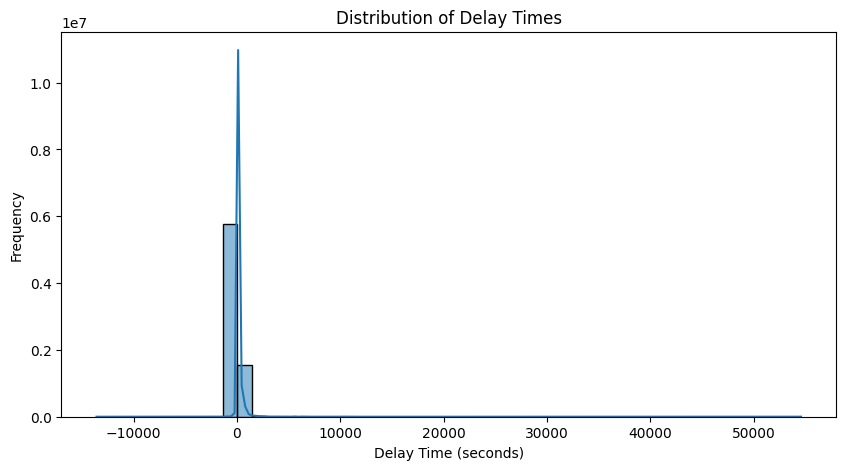

In [54]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_stm_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram.png', bbox_inches='tight')
plt.show()

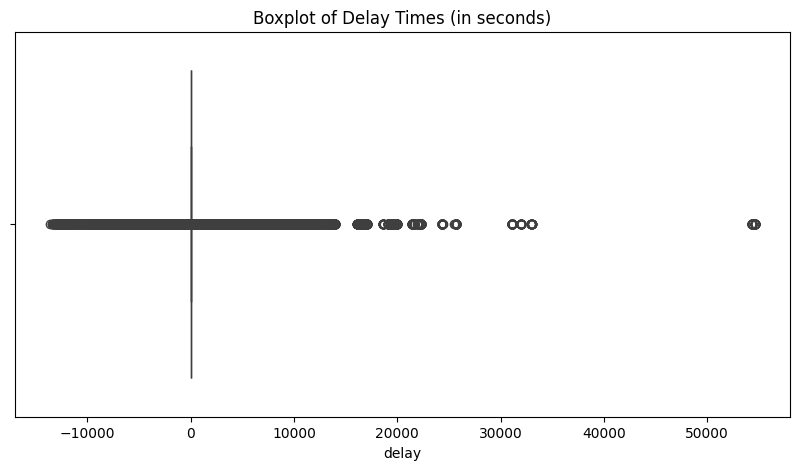

In [55]:
# Plot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_stm_df['delay'])
plt.title('Boxplot of Delay Times (in seconds)')
plt.savefig('../images/delay_boxplot.png', bbox_inches='tight')
plt.show()

The distribution of delay times is highly skewed, with most values concentrated near 0, but extending both negatively and positively in a wide range. There are extreme outliers stretching up to 55000 seconds (more than 15 hours) and also negative values going beyond -10000 seconds (almost 3 hours). Such extreme values are unrealistic for transit delays. It's very likely they represent data entry errors, sensor glitches or edge cases (canceled trips, detours, etc.).

In [56]:
print(merged_stm_df['delay'].max() / merged_stm_df['delay'].min())

-4.015965273690406


In [57]:
# Filter outliers, based on expected trip duration and "skewness" (positive delay is about 4x negative delay)
# If a delay is longer than the expected trip duration, it's most likely a cancelled trip.
outlier_mask = (merged_stm_df['delay'] <= merged_stm_df['exp_trip_duration'] * -0.25) | (merged_stm_df['delay'] >= merged_stm_df['exp_trip_duration'])

In [58]:
# Inspect outliers
outliers_df = merged_stm_df[outlier_mask]
outliers_df[['trip_id', 'route_id', 'stop_name', 'route_direction', 'trip_progress', 'sch_arrival_time', 'delay', 'schedule_relationship']].sort_values('delay', ascending=False)

,trip_id,route_id,stop_name,route_direction,trip_progress,sch_arrival_time,delay,schedule_relationship
161070,283553409,97,du Mont-Royal / De La Roche,West,0.694444,2025-04-28 05:34:00+00:00,54585.0,0
161081,283553409,97,Parc du Mont-Royal,West,1.000000,2025-04-28 05:46:00+00:00,54585.0,0
161080,283553409,97,du Mont-Royal / Jeanne-Mance,West,0.972222,2025-04-28 05:44:00+00:00,54585.0,0
161079,283553409,97,du Mont-Royal / Saint-Urbain,West,0.944444,2025-04-28 05:42:52+00:00,54585.0,0
161051,283553409,97,du Mont-Royal / De Chambly,West,0.166667,2025-04-28 05:19:41+00:00,54585.0,0
...,...,...,...,...,...,...,...,...
3591404,285009528,209,Gare Roxboro-Pierrefonds,North,1.000000,2025-05-02 23:06:00+00:00,-13318.0,0
2174565,285009528,209,de Pierrefonds / Gouin,North,0.923077,2025-04-30 23:01:37+00:00,-13329.0,0
2174566,285009528,209,Gouin / 6e Avenue,North,0.948718,2025-04-30 23:02:21+00:00,-13373.0,0
2174567,285009528,209,Gare Roxboro-Pierrefonds,North,0.974359,2025-04-30 23:03:00+00:00,-13412.0,0


In [59]:
# Calculate proportion
print(f'{outlier_mask.mean():.2%}')

0.34%


In [60]:
# Remove outliers
merged_stm_df = merged_stm_df[~outlier_mask].reset_index(drop=True)

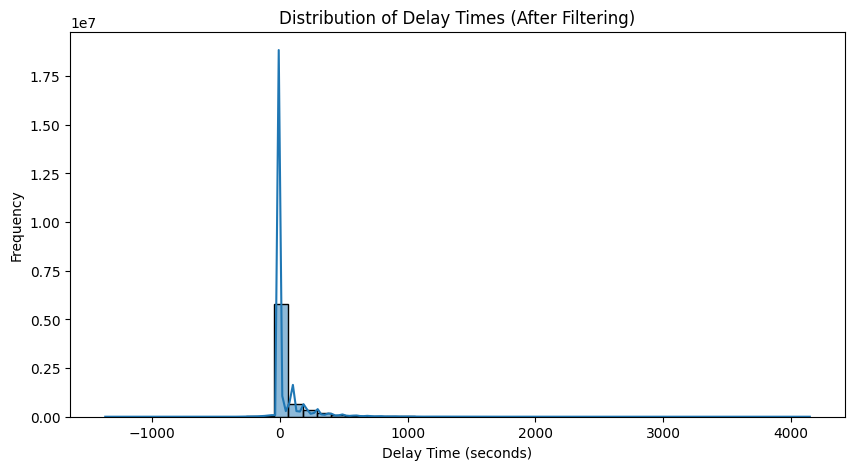

In [61]:
# Replot histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_stm_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times (After Filtering)')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram_filtered.png', bbox_inches='tight')
plt.show()

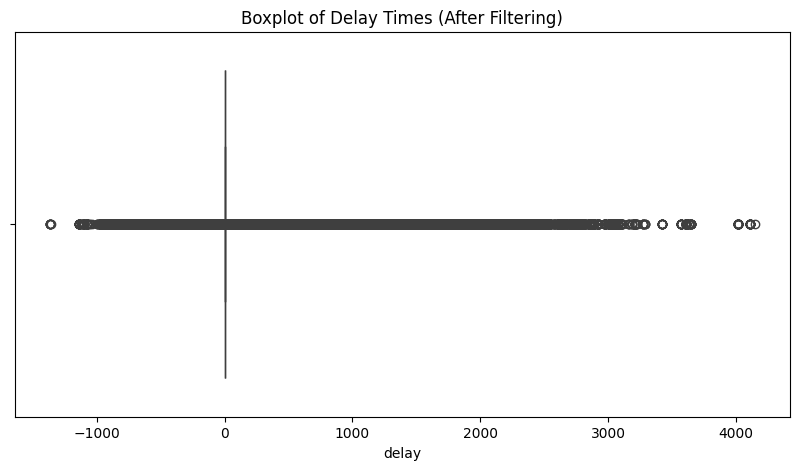

In [62]:
# Replot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_stm_df['delay'])
plt.title('Boxplot of Delay Times (After Filtering)')
plt.savefig('../images/delay_boxplot_filtered.png', bbox_inches='tight')
plt.show()

In [63]:
# Get null delays count
print(merged_stm_df['delay'].isna().sum())

195795


In [64]:
# Replace the null delays with the overall average delay
merged_stm_df['delay'] = merged_stm_df['delay'].fillna(merged_stm_df['delay'].mean())
assert merged_stm_df['delay'].isna().sum() == 0

In [65]:
# Get new distribution
merged_stm_df['delay'].describe()

count    7.530892e+06
mean     5.508555e+01
std      1.662325e+02
min     -1.365000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      8.000000e+00
max      4.147000e+03
Name: delay, dtype: float64

In [66]:
merged_stm_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'rt_arrival_time', 'rt_departure_time', 'schedule_relationship',
       'arrival_time', 'departure_time', 'first_stop_id', 'last_stop_id',
       'stop_sequence', 'trip_progress', 'stop_name', 'neighbourhood',
       'stop_lat', 'stop_lon', 'location_type', 'wheelchair_boarding',
       'exp_trip_duration', 'stop_distance', 'route_direction',
       'start_date_dt', 'sch_arrival_time', 'sch_departure_time',
       'arrival_hour', 'arrivals_per_hour', 'delay'],
      dtype='object')

In [67]:
# Remove uneeded columns
merged_stm_df = merged_stm_df.drop(['current_time', 'start_date', 'start_date_dt', 'arrival_time', 'departure_time', 'arrival_hour'], axis=1)

### Route Types

In [68]:
stm_df = pd.merge(left=merged_stm_df, right=routes_df, how='inner', on='route_id')

In [69]:
stm_df.columns

Index(['trip_id', 'route_id', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'first_stop_id',
       'last_stop_id', 'stop_sequence', 'trip_progress', 'stop_name',
       'neighbourhood', 'stop_lat', 'stop_lon', 'location_type',
       'wheelchair_boarding', 'exp_trip_duration', 'stop_distance',
       'route_direction', 'sch_arrival_time', 'sch_departure_time',
       'arrivals_per_hour', 'delay', 'route_type'],
      dtype='object')

### STM and Weather

In [70]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  312 non-null    object 
 1   temperature_2m        312 non-null    float64
 2   relative_humidity_2m  312 non-null    int64  
 3   precipitation         312 non-null    float64
 4   pressure_msl          312 non-null    float64
 5   cloud_cover           312 non-null    int64  
 6   wind_speed_10m        312 non-null    float64
 7   wind_direction_10m    312 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 19.6+ KB


In [71]:
# Convert time string to datetime
time_dt = pd.to_datetime(weather_df['time'], utc=True)

In [72]:
# Round arrival time to the nearest hour
rounded_arrival_dt = stm_df['sch_arrival_time'].dt.round('h')

In [73]:
# Format time to match weather data
stm_df['time'] = rounded_arrival_dt.dt.strftime('%Y-%m-%dT%H:%M')

In [74]:
# Merge STM with weather
df = pd.merge(left=stm_df, right=weather_df, how='inner', on='time').drop('time', axis=1)

## Clean Data

### Drop Columns

In [75]:
# Remove columns with constant values or with more than 50% missing values
df = df.loc[:, (df.nunique() > 1) & (df.isna().mean() < 0.5)]
df.columns

Index(['trip_id', 'route_id', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'first_stop_id',
       'last_stop_id', 'stop_sequence', 'trip_progress', 'stop_name',
       'stop_lat', 'stop_lon', 'wheelchair_boarding', 'exp_trip_duration',
       'stop_distance', 'route_direction', 'sch_arrival_time',
       'sch_departure_time', 'arrivals_per_hour', 'delay', 'route_type',
       'temperature_2m', 'relative_humidity_2m', 'precipitation',
       'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

### Convert columns

In [76]:
# Get columns with two values
two_values = df.loc[:, df.nunique() == 2]
for column in two_values.columns:
  print(df[column].value_counts())

wheelchair_boarding
1    7048632
2     482260
Name: count, dtype: int64


In [77]:
# Convert wheelchair_boarding to boolean
df['wheelchair_boarding'] = (df['wheelchair_boarding'] == 1).astype('int64')

### Convert schedule_relationship and occupancy_status to Categories

In [78]:
def convert_to_categories(df:pd.DataFrame, column:str, map_dict:dict) -> pd.Series:
	codes = df[column].sort_values().unique()
	condition_list = []
	label_list = []
		
	for code in codes:
		condition_list.append(df[column] == code)
		label_list.append(map_dict[code])
	
	df[column] = np.select(condition_list, label_list, default='Unknown')
	return df[column]

In [79]:
df['schedule_relationship'] = convert_to_categories(df, 'schedule_relationship', SCHEDULE_RELATIONSHIP)
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    7335099
Skipped       179390
NoData         16403
Name: count, dtype: int64

## Export Data

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7530892 entries, 0 to 7530891
Data columns (total 29 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   trip_id                int64              
 1   route_id               int64              
 2   stop_id                int64              
 3   rt_arrival_time        datetime64[ns, UTC]
 4   rt_departure_time      datetime64[ns, UTC]
 5   schedule_relationship  object             
 6   first_stop_id          int64              
 7   last_stop_id           int64              
 8   stop_sequence          int64              
 9   trip_progress          float64            
 10  stop_name              object             
 11  stop_lat               float64            
 12  stop_lon               float64            
 13  wheelchair_boarding    int64              
 14  exp_trip_duration      float64            
 15  stop_distance          float64            
 16  route_direction   

In [81]:
df.isna().sum()

trip_id                       0
route_id                      0
stop_id                       0
rt_arrival_time          354528
rt_departure_time        418729
schedule_relationship         0
first_stop_id                 0
last_stop_id                  0
stop_sequence                 0
trip_progress                 0
stop_name                     0
stop_lat                      0
stop_lon                      0
wheelchair_boarding           0
exp_trip_duration             0
stop_distance                 0
route_direction               0
sch_arrival_time              0
sch_departure_time            0
arrivals_per_hour             0
delay                         0
route_type                    0
temperature_2m                0
relative_humidity_2m          0
precipitation                 0
pressure_msl                  0
cloud_cover                   0
wind_speed_10m                0
wind_direction_10m            0
dtype: int64

In [82]:
# Export data to CSV
df.to_parquet('../data/stm_weather_merged.parquet', index=False)

## End